In [1]:
import os.path as op

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import AFQ.registration as reg

In [4]:
from glob import glob
import nibabel as nib

In [5]:
path = '/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/'

In [6]:
real_a_files = glob(op.join(path, 'IXI029*real_A*'))
real_b_files = glob(op.join(path, 'IXI029*real_B*'))
fake_b_files = glob(op.join(path, 'IXI029*fake_B*'))

In [7]:
real_a_files.sort()
real_b_files.sort()
fake_b_files.sort()

In [8]:
real_a = np.zeros((len(real_a_files), 128, 128, 3))
real_b = np.zeros((len(real_a_files), 128, 128, 3))
fake_b = np.zeros((len(real_a_files), 128, 128, 3))
for ii in range(len(real_a_files)):
    real_a[ii]= np.load(real_a_files[ii]) 
    real_b[ii]= np.load(real_b_files[ii]) 
    fake_b[ii]= np.load(fake_b_files[ii])

(-0.5, 127.5, 127.5, -0.5)

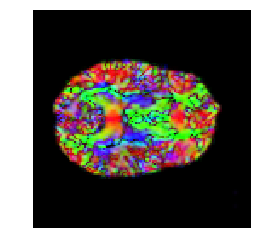

In [9]:
fig, ax = plt.subplots(1)
ax.imshow(np.abs(fake_b[27]))
ax.axis("off")

In [10]:
meanV1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmean_V1.nii.gz')

In [11]:
meanV1 = meanV1_img.get_data()

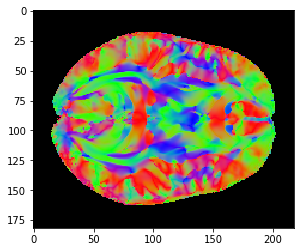

In [12]:
plt.imshow(np.abs(meanV1[:, :, 80]))

In [13]:
meant1_img = nib.load('/Users/arokem/data/mri2mri/IIT-templates/IITmean_t1.nii.gz')

In [14]:
meant1 = meant1_img.get_data()

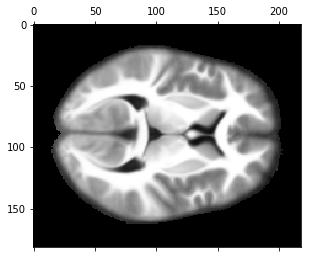

In [15]:
plt.matshow(meant1[:, :, 80], cmap='gray')

In [16]:
meanV1.shape

(182, 218, 182, 3)

In [17]:
meant1.shape

(182, 218, 182)

In [18]:
ants_brain_img = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-T1_ants_brain_onlyBrainExtractionBrain.nii.gz')

In [19]:
ants_brain = ants_brain_img.get_data()

In [20]:
transformed, affine = reg.affine_registration(meant1, ants_brain, meant1_img.affine, ants_brain_img.affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [21]:
warped_meant1, mapping = reg.syn_registration(meant1, ants_brain, moving_affine=meant1_img.affine, static_affine=ants_brain_img.affine, prealign=affine)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


In [22]:
nib.save(nib.Nifti1Image(warped_meant1, ants_brain_img.affine), '/Users/arokem/data/mri2mri/meant1_warped_to_ants_brain.nii.gz')

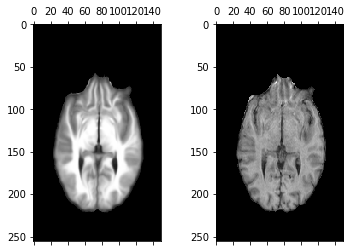

In [23]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(warped_meant1[:, 150, :], cmap='gray')
ax[1].matshow(ants_brain[:, 150, :], cmap='gray')

In [24]:
mapped = np.concatenate([mapping.transform(meanV1[..., 0])[..., np.newaxis], 
                         mapping.transform(meanV1[..., 1])[..., np.newaxis], 
                         mapping.transform(meanV1[..., 2])[..., np.newaxis]], -1) 

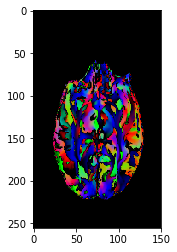

In [25]:
plt.imshow(mapped[:, 150, :])

In [26]:
DWI_img = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-DTI-00.nii.gz')

In [27]:
DWI_affine = DWI_img.affine

In [28]:
resamp = np.concatenate([reg.resample(mapped[..., 0], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                         reg.resample(mapped[..., 1], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                         reg.resample(mapped[..., 2], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis]], -1)[:,:,1:-1]
                         

In [29]:
resamp = np.moveaxis(resamp, 2, 0)

In [63]:
mask_img = ants_brain_img = nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-T1_ants_brain_onlyBrainExtractionMask.nii.gz')

In [64]:
mask_data = mask_img.get_data()

In [65]:
mask_resamp = reg.resample(mask_data, DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[:,:,1:-1]

In [66]:
mask_resamp.shape

(128, 128, 54)

In [67]:
mask_resamp = np.moveaxis(mask_resamp, 2, 0)

In [68]:
mask_resamp.shape

(54, 128, 128)

In [69]:
dwi_data = np.concatenate([nib.load('/Users/arokem/data/mri2mri/IXI029-Guys-0829-DTI-%02d.nii.gz'%digit).get_data()[..., np.newaxis] for digit in range(16)], -1)

In [70]:
dwi_data = np.moveaxis(dwi_data, 2, 0)[1:-1]

In [103]:
from imp import reload

In [117]:
reload(reg)

<module 'AFQ.registration' from '/Users/arokem/source/pyAFQ/AFQ/registration.py'>

In [118]:
dwi_data.shape

(54, 128, 128, 16)

In [119]:
transformed_list, affine_list = reg.register_series(nib.Nifti1Image(dwi_data, DWI_affine), 
                                                    15, 
                                                    pipeline=[reg.affine])

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter

In [122]:
xform_dwi_data = np.array(transformed_list)

In [123]:
xform_dwi_data.shape

(16, 54, 128, 128)

In [125]:
xform_dwi_data = np.moveaxis(xform_dwi_data, 0, 3)

In [126]:
xform_dwi_data.shape

(54, 128, 128, 16)

In [127]:
from dipy.core import gradients as dpg

In [128]:
gtab = dpg.gradient_table('/Users/arokem/data/mri2mri/bvals.txt', '/Users/arokem/data/mri2mri/bvecs.txt')

In [129]:
from dipy.reconst import dti

In [130]:
dtm = dti.TensorModel(gtab)

In [131]:
dtf = dtm.fit(xform_dwi_data, mask=mask_resamp)

In [81]:
nib.save(nib.Nifti1Image(real_b, DWI_affine), '/Users/arokem/data/mri2mri/real_b.nii.gz')

In [82]:
ax0 = ax[0]

In [83]:
real_b.shape

(54, 128, 128, 3)

In [84]:
resamp.shape

(54, 128, 128, 3)

In [138]:
wm_mask = dtf.fa > 0.3

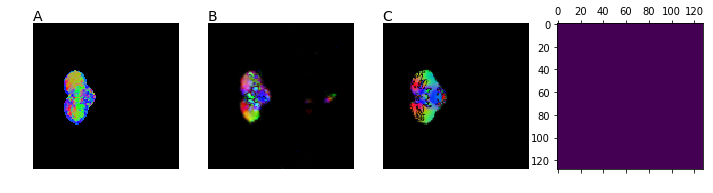

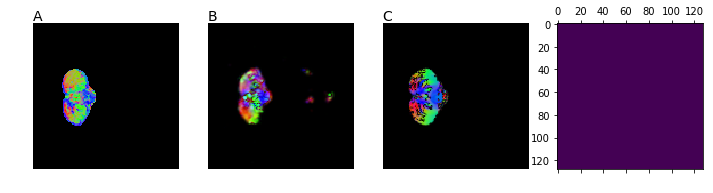

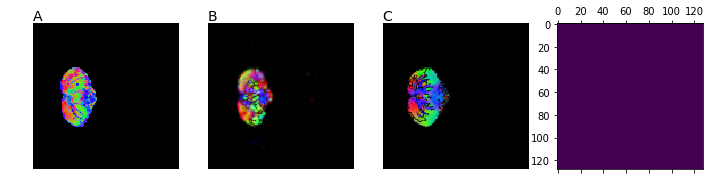

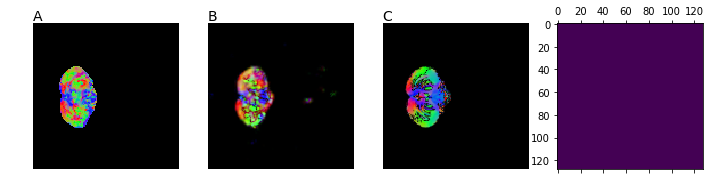

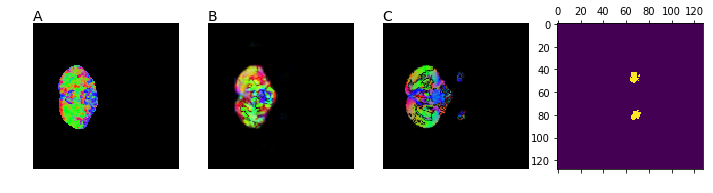

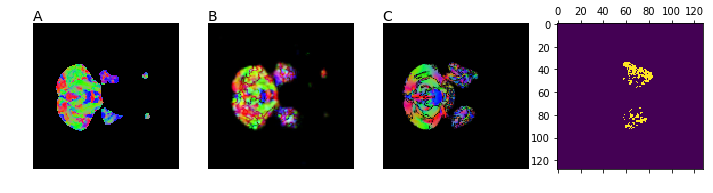

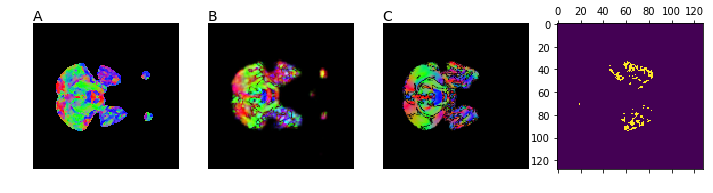

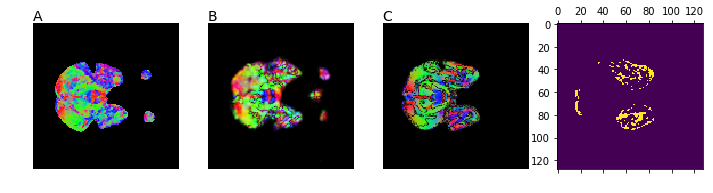

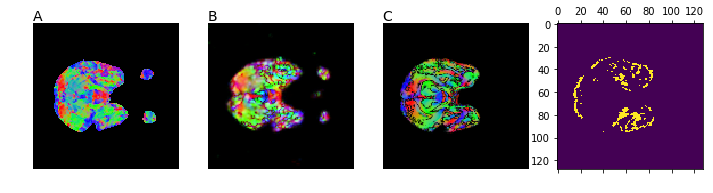

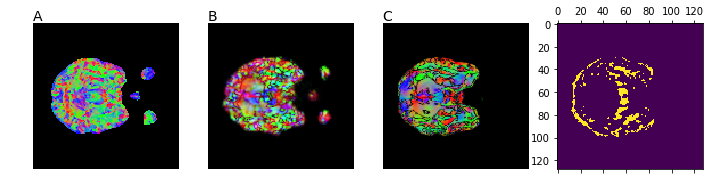

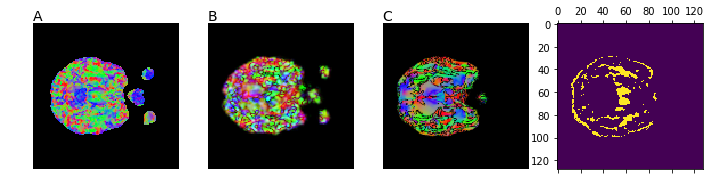

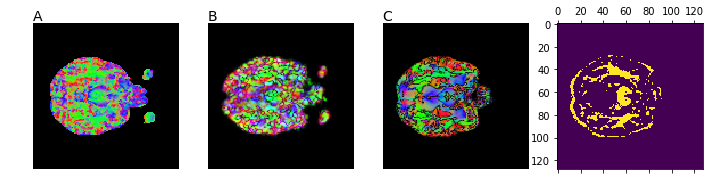

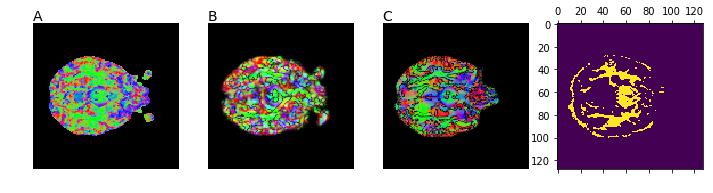

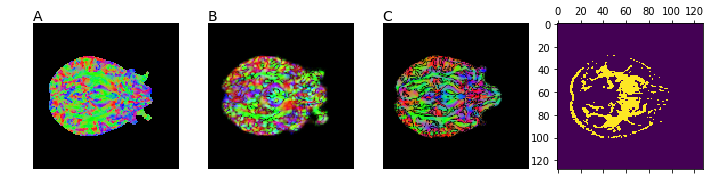

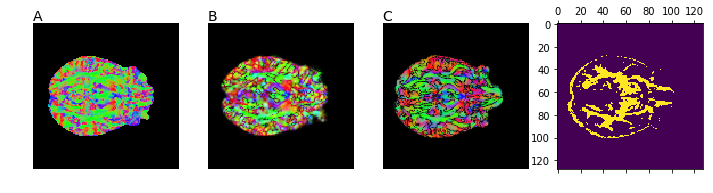

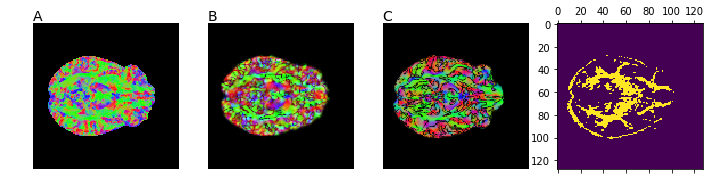

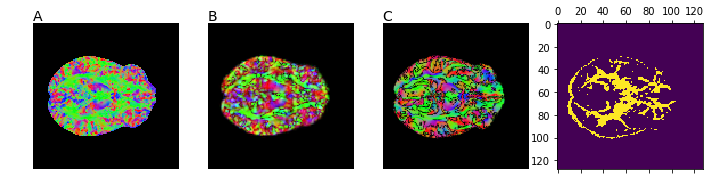

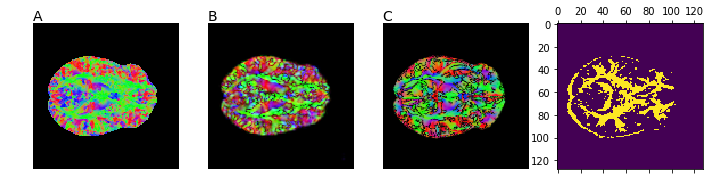

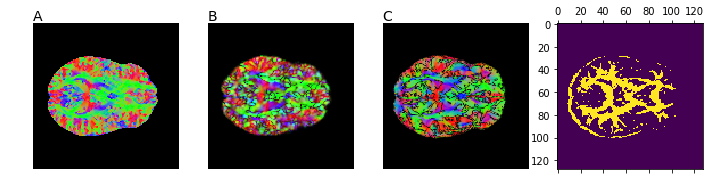

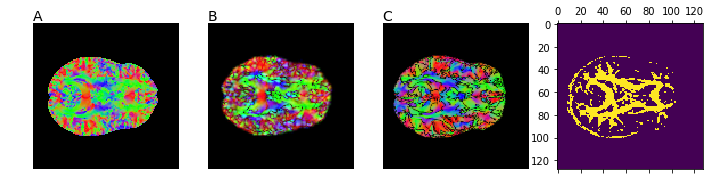

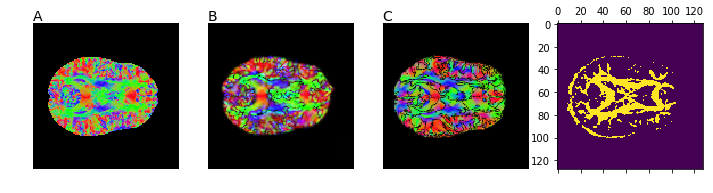

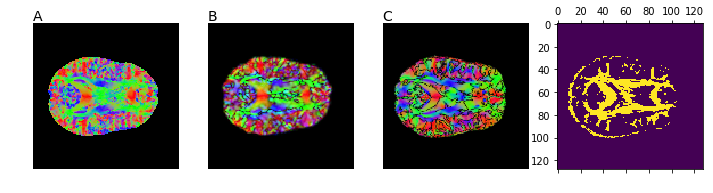

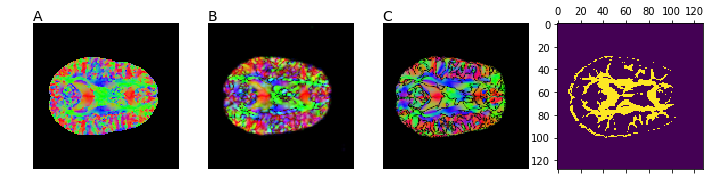

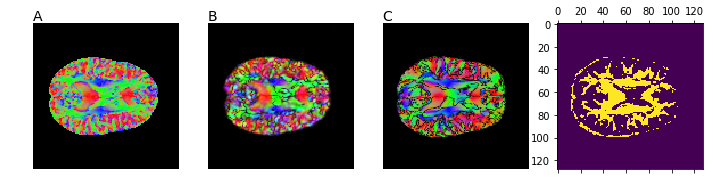

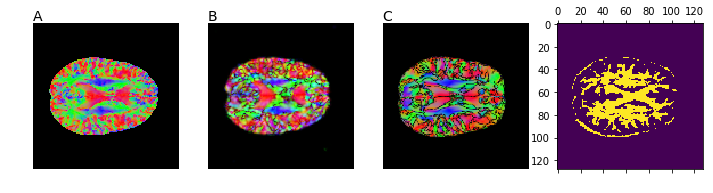

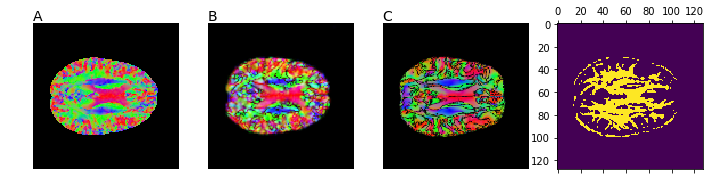

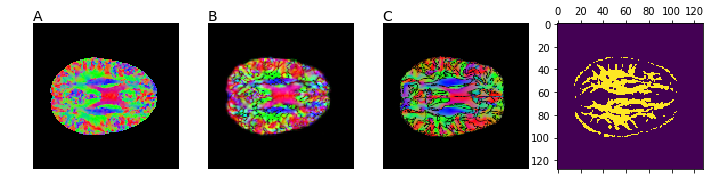

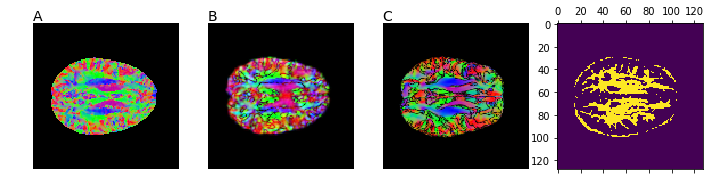

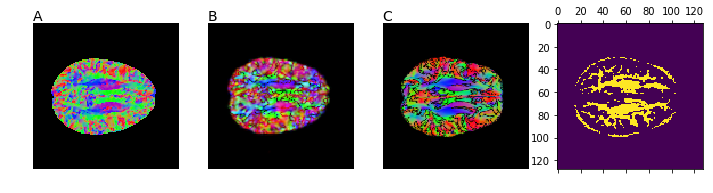

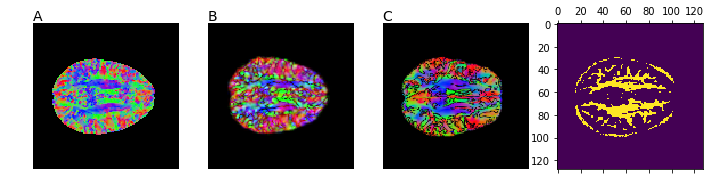

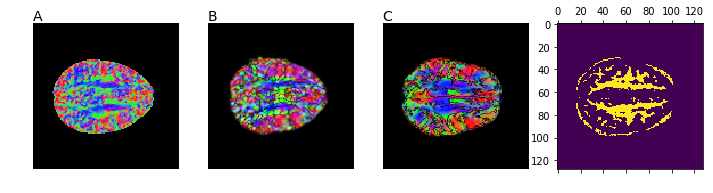

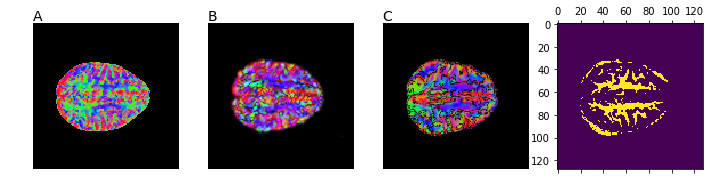

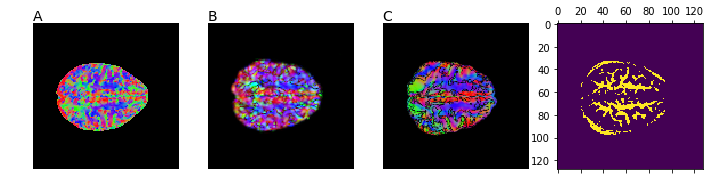

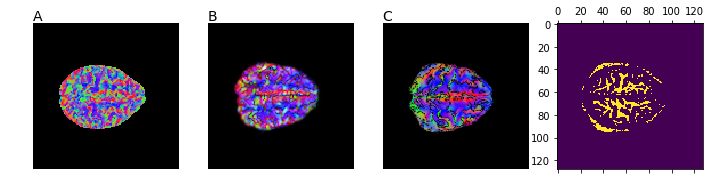

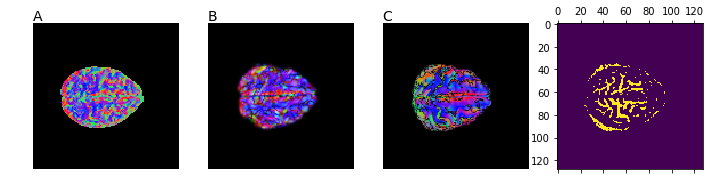

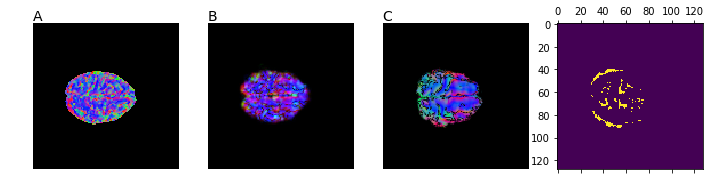

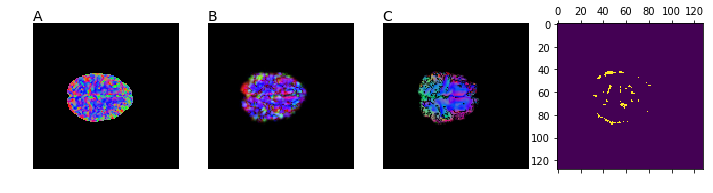

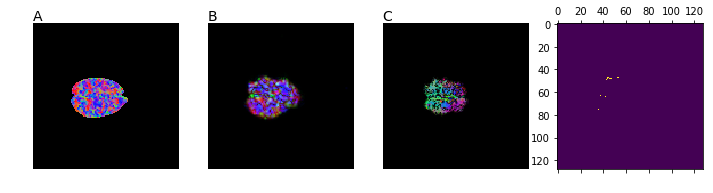

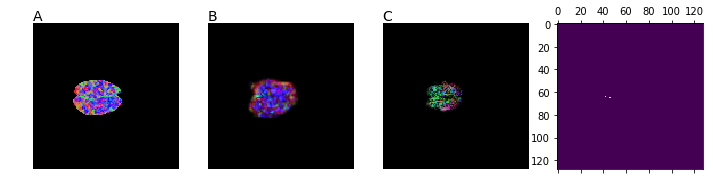

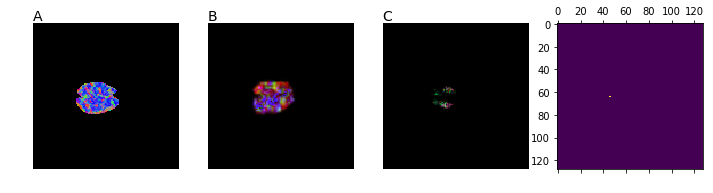

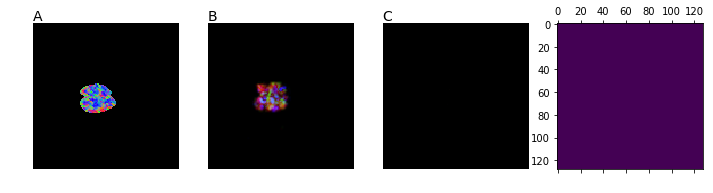

In [139]:
for ii in range(real_b.shape[0]):
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(np.abs(real_b[ii]), interpolation="nearest")
    ax[0].axis("off")
    ax[0].text(0, 1.05, 'A', horizontalalignment='left',
               verticalalignment='center', transform=ax[0].transAxes, fontsize=14)
    ax[1].imshow(np.abs(fake_b[ii]), interpolation="nearest")
    ax[1].axis("off")
    ax[1].text(0, 1.05, 'B', horizontalalignment='left',
               verticalalignment='center', transform=ax[1].transAxes, fontsize=14)
    ax[2].imshow(np.abs(resamp[ii]), interpolation="nearest")
    ax[2].axis("off")
    ax[2].text(0, 1.05, 'C', horizontalalignment='left',
               verticalalignment='center', transform=ax[2].transAxes, fontsize=14)
    ax[3].matshow(wm_mask[ii], vmin=0, vmax=1)
    fig.set_size_inches([12, 10])


In [141]:
angle_fake = np.rad2deg(np.arccos(np.clip((real_b[wm_mask] * fake_b[wm_mask]).sum(axis=-1), -1, 1)))
    
angle_fake = np.min(np.array([angle_fake, 180-angle_fake]), 0)

In [142]:
angle_template = np.rad2deg(np.arccos(np.clip((real_b[wm_mask] * resamp[wm_mask]).sum(axis=-1), -1, 1)))
angle_template = np.min(np.array([angle_template, 180-angle_template]), 0)

In [143]:
fig, ax = plt.subplots(1)
ax.hist(angle_fake, histtype='step', bins=20, label="NN")
ax.hist(angle_template, histtype='step', bins=20, label="Template")
plt.legend(loc="upper left")

In [90]:
errormap_template = np.zeros(real_b.shape[:3]) * np.nan
errormap_fake = np.zeros(real_b.shape[:3]) * np.nan

In [91]:
errormap_template[mask] = angle_template

In [92]:
errormap_fake[mask] = angle_fake

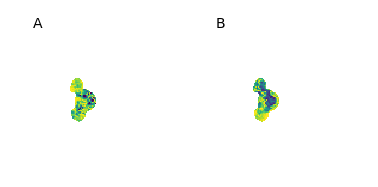

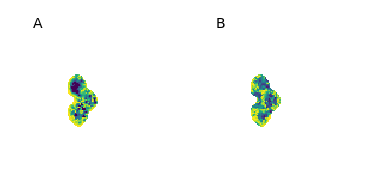

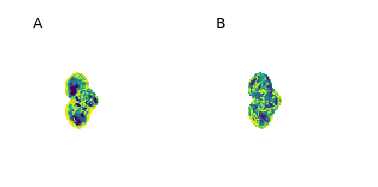

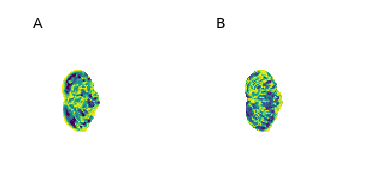

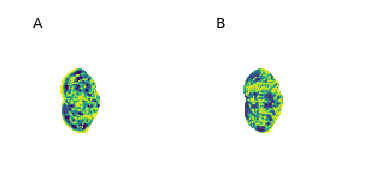

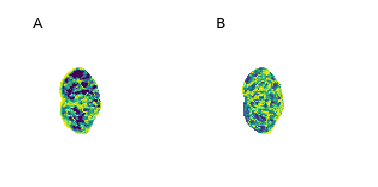

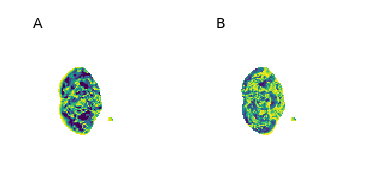

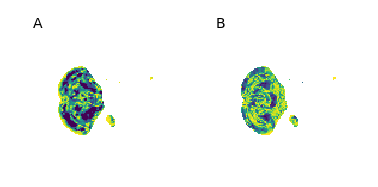

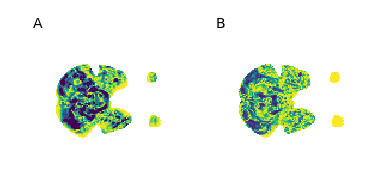

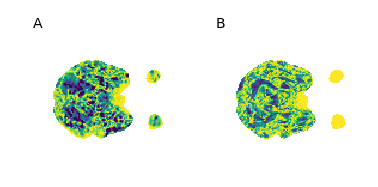

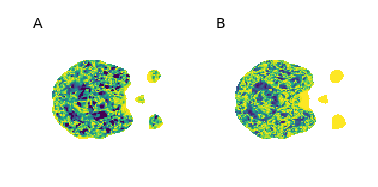

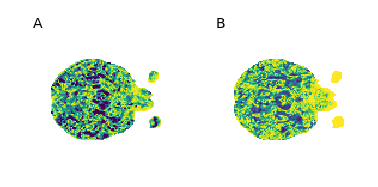

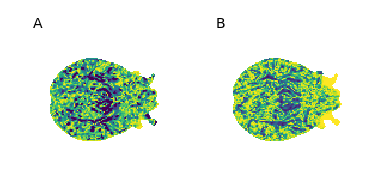

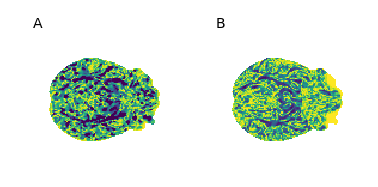

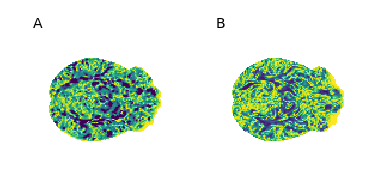

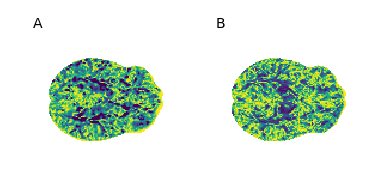

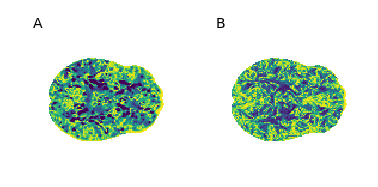

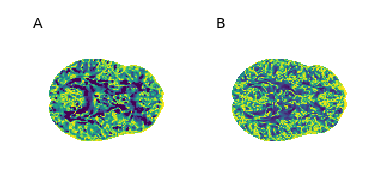

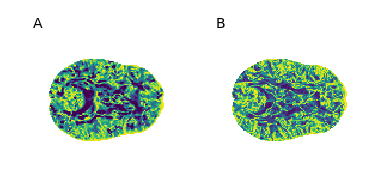

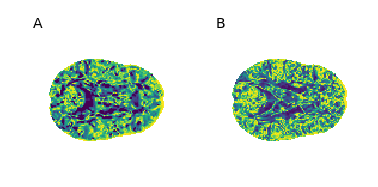

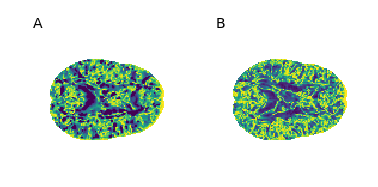

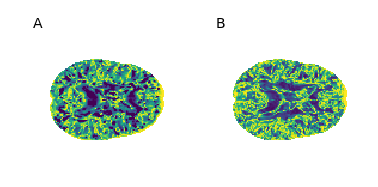

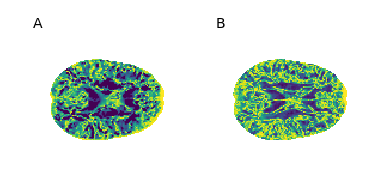

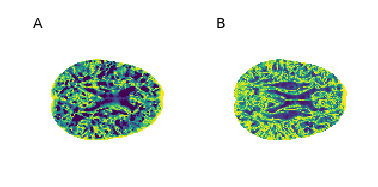

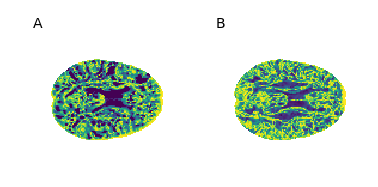

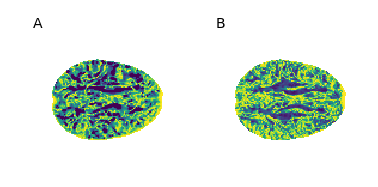

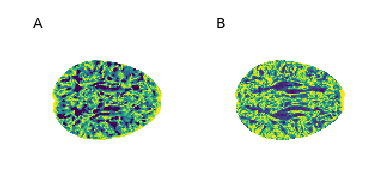

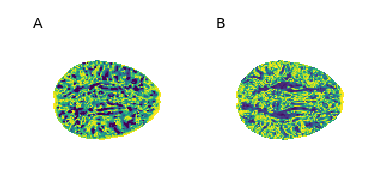

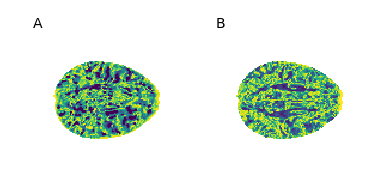

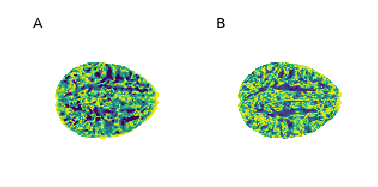

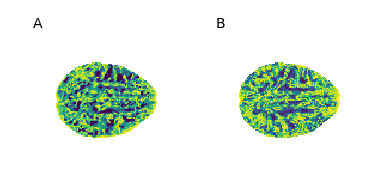

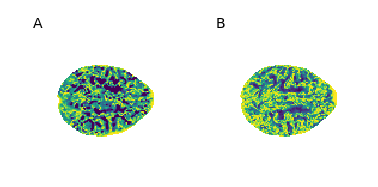

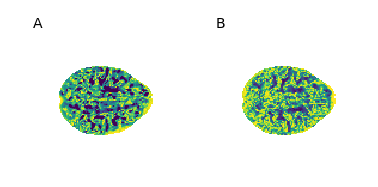

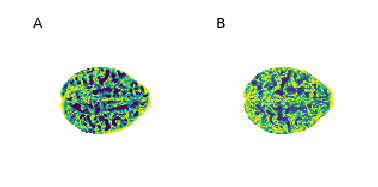

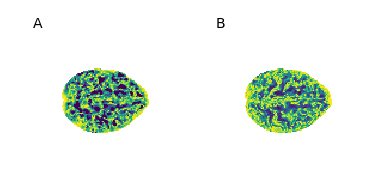

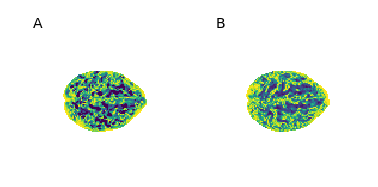

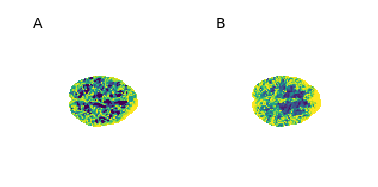

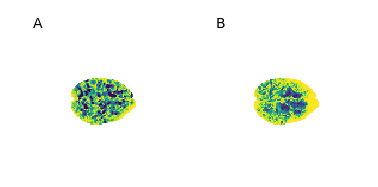

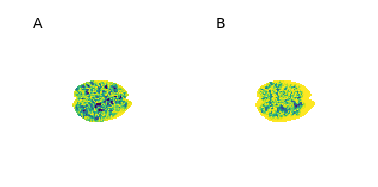

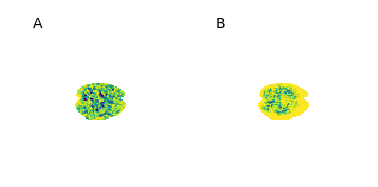

In [93]:
for ii in range(errormap_fake.shape[0]):
    fig, ax = plt.subplots(1, 2)
    ax[0].matshow(np.abs(errormap_fake[ii]), vmin=0, vmax=90)
    ax[0].axis("off")
    ax[0].text(0, 1, 'A', horizontalalignment='left',
               verticalalignment='center', transform=ax[0].transAxes, fontsize=14)
    ax[1].matshow(np.abs(errormap_template[ii]), vmin=0, vmax=90)
    ax[1].axis("off")
    ax[1].text(0, 1, 'B', horizontalalignment='left',
               verticalalignment='center', transform=ax[1].transAxes, fontsize=14)


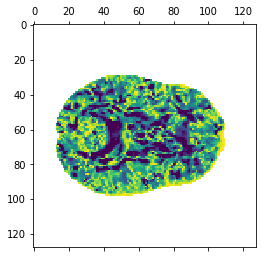

In [94]:
plt.matshow(errormap_fake[27], vmin=0, vmax=90)

In [95]:
plt.matshow(errormap_template[27], vmin=0, vmax=90)